In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
base_data = pd.read_csv('FINAL_ARXIV_2025_copy.csv')
authors_1 = pd.read_csv('papers_with_ads_metrics_1.csv')
authors_2 = pd.read_csv('papers_with_ads_metrics_2.csv')

In [60]:
authors_1['affiliations'][11]

'Nyadzani, Lutendo: Centre for Astro-Particle Physics (CAPP) and Department of Physics, University of Johannesburg, PO Box 524, Auckland Park, 2006, South Africa;; Razzaque, Soebur: Centre for Astro-Particle Physics (CAPP) and Department of Physics, University of Johannesburg, PO Box 524, Auckland Park, 2006, South Africa; Department of Physics, The George Washington University, Washington, DC, 20052, USA; National Institute for Theoretical and Computational Sciences (NITheCS), Private Bag X1, Matieland, South Africa;; Finke, Justin D.: U.S. Naval Research Laboratory, Code 7653, 4555 Overlook Ave. SW, Washington, DC, 20375-5352, USA;'

In [61]:
# Concatenate the two authors dataframes first since they have the same structure
all_authors = pd.concat([authors_1, authors_2], ignore_index=True)

# Merge base_data with the combined authors dataframe on 'title'
# 'left' join keeps all rows from base_data
merged_data = base_data.merge(
    all_authors[['title', 'affiliations', 'total_citations', 'non_self_citations']], 
    on='title', 
    how='left'
)


In [62]:
import re
import ast
import pandas as pd

def normalize_name(name):
    if not isinstance(name, str):
        return ""
    return name.replace('-', '').replace(' ', '').lower()

def extract_affiliations_list(row):
    authors_str = row['authors']
    affil_str = row['affiliations']
    
    try:
        authors = ast.literal_eval(authors_str) if isinstance(authors_str, str) else []
    except:
        authors = []
        
    if not authors:
        return []
    
    if pd.isna(affil_str):
        return [None] * len(authors)
        
    # Split by Name: (no colons or semicolons allowed in name)
    parts = re.split(r'(?:^|;|;;)\s*([^:;]+):', affil_str)
    
    affil_map = {}
    
    for i in range(1, len(parts), 2):
        name_key = parts[i].strip()
        affil_val = parts[i+1].strip()
        affil_val = re.sub(r'[;]+$', '', affil_val).strip()
        
        # 1. Map original name
        affil_map[name_key] = affil_val
        
        # 2. Map normalized name
        affil_map[normalize_name(name_key)] = affil_val
        
        # 3. Handle "Last, First" -> "First Last" mapping
        if ',' in name_key:
            last, first = name_key.split(',', 1)
            first_last = f"{first.strip()} {last.strip()}"
            affil_map[first_last] = affil_val
            affil_map[normalize_name(first_last)] = affil_val
            
            # 4. Handle 'ü' -> 'v' substitution (common in Chinese names transliteration)
            if 'ü' in name_key:
                name_v = name_key.replace('ü', 'v')
                first_last_v = first_last.replace('ü', 'v')
                affil_map[normalize_name(name_v)] = affil_val
                affil_map[normalize_name(first_last_v)] = affil_val
                
    result = []
    for author in authors:
        # Try looking up by exact match
        affil = affil_map.get(author)
        
        # Try looking up by normalized match
        if affil is None:
            affil = affil_map.get(normalize_name(author))
            
        # Try constructing Last, First key manually from Author string if not found
        if affil is None:
            parts_name = author.split()
            if len(parts_name) > 1:
                # "First Middle Last" -> "Last, First Middle"
                last_first = f"{parts_name[-1]}, {' '.join(parts_name[:-1])}"
                affil = affil_map.get(last_first)
                if affil is None:
                    affil = affil_map.get(normalize_name(last_first))
                    
        # Handle ü -> v check for author name input too
        if affil is None and 'v' in author:
             # e.g. Author is "Lv", Key might be "Lü"
             # This direction is harder to map solely via map keys unless we permute author string
             # But we enriched the map with 'v' versions of 'ü' keys.
             # If the author has 'v', and key has 'v', it should match via normalized map.
             # What if Author has 'Lv' and key has 'Lv' (already matched)?
             pass
        
        result.append(affil)
        
    return result

merged_data['affiliations'] = merged_data.apply(extract_affiliations_list, axis=1)
merged_data[['authors', 'affiliations']].head(10)

,authors,affiliations
0,['John F. Wu'],"[Space Telescope Science Institute, 3700 San M..."
1,"[""Patrick O'Neill"", 'Adam Ingram', 'Edward Nat...","[None, None, None, None, None, None, None]"
2,"[""Matteo D'Andrea"", 'Claudio Macculi', 'Simone...","[INAF/IAPS, 00133, Rome, Italy, INAF/IAPS, 001..."
3,"['Giada Peron', 'Giovanni Morlino', 'Stefano G...","[None, None, None, None]"
4,"['Jie Liu', 'Zhi Li', 'Juntai Shen']","[Shanghai Astronomical Observatory, Chinese Ac..."
5,"['Xiao-long He', 'Guo-liang Lv', 'Chun-hua Zhu...","[School of Physical Science and Technology, Xi..."
6,['C. Martin Gaskell'],[None]
7,"['G. Castelló', 'M. Luna', 'J. Terradas']","[Departament de Física, Universitat de les Ill..."
8,"['Piyush Sharda', 'Shyam H. Menon', 'Roman Ger...","[Leiden Observatory, Leiden University, PO Box..."
9,['Riccardo Ferrazzoli'],[INAF]


In [52]:
merged_data['affiliations'][11]

['Centre for Astro-Particle Physics (CAPP) and Department of Physics, University of Johannesburg, PO Box 524, Auckland Park, 2006, South Africa',
 'Centre for Astro-Particle Physics (CAPP) and Department of Physics, University of Johannesburg, PO Box 524, Auckland Park, 2006, South Africa; Department of Physics, The George Washington University, Washington, DC, 20052, USA; National Institute for Theoretical and Computational Sciences (NITheCS), Private Bag X1, Matieland, South Africa',
 'U.S. Naval Research Laboratory, Code 7653, 4555 Overlook Ave. SW, Washington, DC, 20375-5352, USA']

In [65]:
# Separating the countries from the affiliations
def get_countries(affiliations_list):
    if not isinstance(affiliations_list, list):
        return []
    countries = []
    for affil in affiliations_list:
        if affil and isinstance(affil, str):
            # Assume country is after the last comma
            # Split by comma and take the last part
            country = affil.split(',')[-1].strip()
            # Remove any ending characters like ' or ] or . or "
            # Regex: r"['\]\.\"]+$"
            country = re.sub(r"['\]\.\"]+$", "", country)
            countries.append(country)
        else:
            countries.append(None)
    return countries

merged_data['countries'] = merged_data['affiliations'].apply(get_countries)
merged_data[['affiliations', 'countries']].head()

,affiliations,countries
0,"[Space Telescope Science Institute, 3700 San M...",[USA]
1,"[None, None, None, None, None, None, None]","[None, None, None, None, None, None, None]"
2,"[INAF/IAPS, 00133, Rome, Italy, INAF/IAPS, 001...","[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
3,"[None, None, None, None]","[None, None, None, None]"
4,"[Shanghai Astronomical Observatory, Chinese Ac...","[People's Republic of China, People's Republic..."


In [115]:
# Accounting for difference in country names 
replacement_dict = {
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'United States of America': 'United States',
    "People's Republic of China": 'China',
    'The Netherlands': 'Netherlands',
    'Republic of Korea': 'South Korea',
    'The United Kingdom': 'United Kingdom'
}


for i in range(len(merged_data)):
    for j in range(len(merged_data[i]['countries'])):
        merged_data[i]['countries'][j] = replacement_dict.get(merged_data[i]['countries'][j], merged_data[i]['countries'][j])

KeyError: 0

In [110]:
# First Country
merged_data['first_country'] = merged_data['countries'].apply(lambda x: x[0] if x else None)

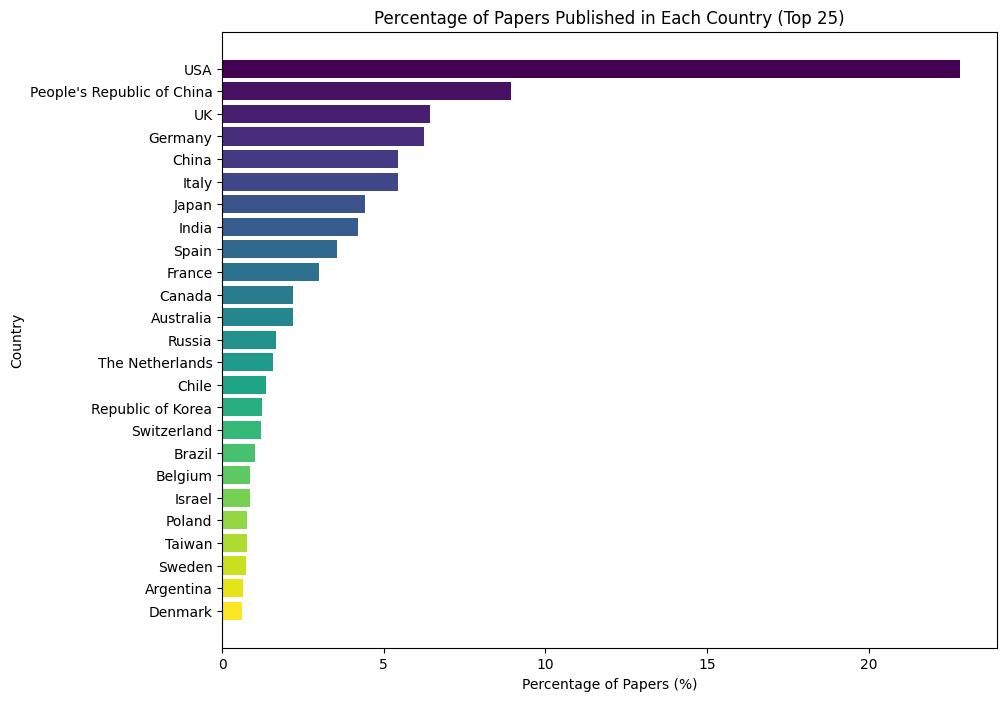

In [111]:
# Plotting percentage of papers published in each journal
country_counts = merged_data['first_country'].value_counts(normalize=True).head(25) * 100
plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(country_counts))))
plt.xlabel('Percentage of Papers (%)')
plt.ylabel('Country')
plt.title('Percentage of Papers Published in Each Country (Top 25)')
plt.gca().invert_yaxis()
plt.show()

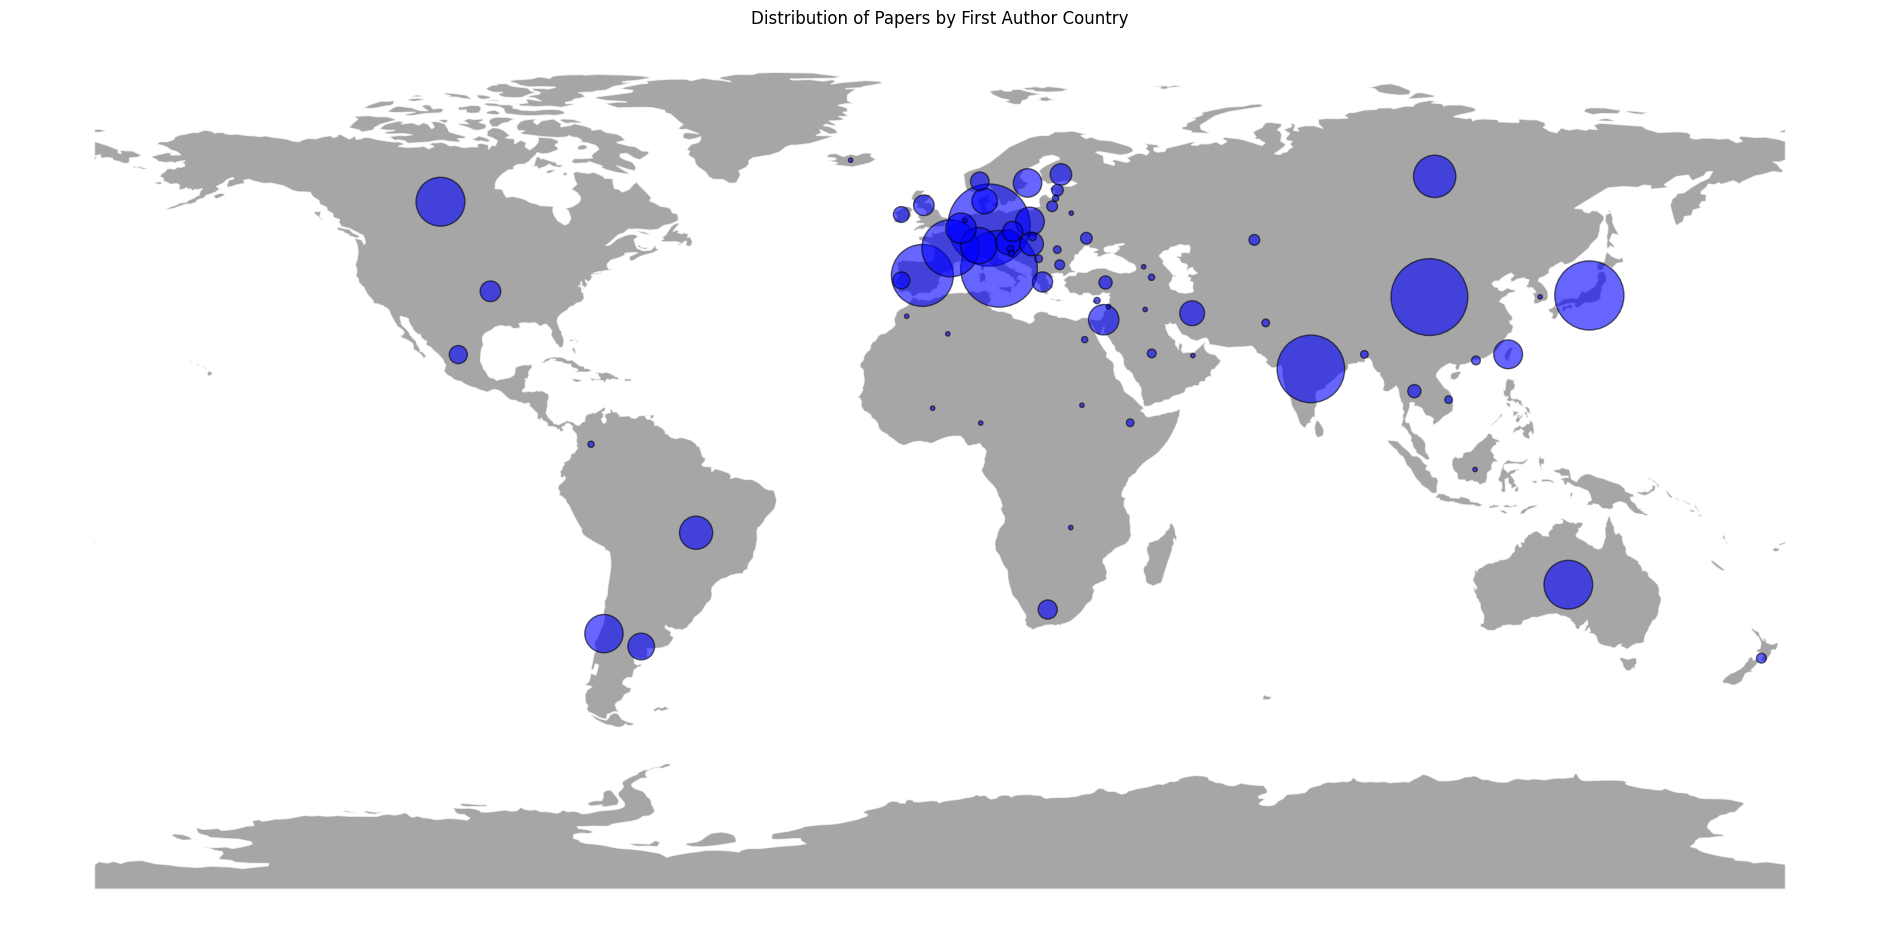

In [ ]:
# Visualization of Country Distribution (Local CSV)
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 2. Aggregate counts
country_counts = merged_data['first_country'].value_counts().reset_index()
country_counts.columns = ['country', 'repeats']

# 3. Load Coordinates from CSV
try:
    coords_df = pd.read_csv('world_coords.csv')
    # Ensure we use specific columns
    coords_df = coords_df[['country', 'latitude', 'longitude']]
except Exception as e:
    print(f"Error loading world_coords.csv: {e}")
    coords_df = pd.DataFrame(columns=['country', 'latitude', 'longitude'])

# 4. Merge Data
# Inner join to match countries present in our coordinates file
df_plot = country_counts.merge(coords_df, on='country', how='inner')

# 5. Plot
try:
    try:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    except:
        import geodatasets
        world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

    fig, ax = plt.subplots(figsize=(24, 18))
    world.plot(ax=ax, alpha=0.7, color="grey", edgecolor='white')
    
    plt.scatter(df_plot['longitude'], df_plot['latitude'], 
                s=10 * df_plot['repeats'], 
                alpha=0.6, c='blue', edgecolors='k')
    
    plt.title('Distribution of Papers by First Author Country')
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error plotting map: {e}")


In [93]:
df_plot

,country,repeats,latitude,longitude
0,Germany,350,51.165691,10.451526
1,China,306,35.861660,104.195397
2,Italy,305,41.871940,12.567380
3,Japan,248,36.204824,138.252924
4,India,237,20.593684,78.962880
...,...,...,...,...
67,United Arab Emirates,1,23.424076,53.847818
68,Zambia,1,-13.133897,27.849332
69,Morocco,1,31.791702,-7.092620
70,Iraq,1,33.223191,43.679291
